In [ ]:
!pip install finnhub-python

In [ ]:
import yfinance as yf
import datetime
import pandas as pd

symbol = "AAPL"
stock = yf.Ticker(symbol)

# Fetch last 100 days of stock data
df = stock.history(period="1000d")

# Add VWAP (Approximate)
df["VWAP"] = (df["High"] + df["Low"] + df["Close"]) / 3

# Get yesterday’s date with timezone information
today = pd.Timestamp.today(tz='America/New_York').floor('D') # Ensures timezone-aware timestamp
yesterday = today - pd.Timedelta(days=1)

# Get yesterday's data (second-last row in df)
yesterday_data = df.iloc[-2]

# Create a new DataFrame row for yesterday
yesterday_df = pd.DataFrame({
    "Open": [yesterday_data["Open"]],
    "High": [yesterday_data["High"]],
    "Low": [yesterday_data["Low"]],
    "Close": [yesterday_data["Close"]],
    "Volume": [yesterday_data["Volume"]],
    "VWAP": [yesterday_data["VWAP"]],
    "Dividends": [yesterday_data["Dividends"]],
    "Stock Splits": [yesterday_data["Stock Splits"]]
}, index=[yesterday])  # Set yesterday's date as index

# Append yesterday's data to df
df = pd.concat([df, yesterday_df])

# Print first 5 rows
print(df.head(5))  # Show last 5 rows including yesterda

                                 Open        High         Low       Close  \
2021-03-02 00:00:00-05:00  125.615889  125.919141  122.289869  122.397476   
2021-03-03 00:00:00-05:00  122.094230  122.974648  119.188854  119.404068   
2021-03-04 00:00:00-05:00  119.100797  120.910541  116.038907  117.516045   
2021-03-05 00:00:00-05:00  118.347556  119.286666  115.011752  118.777977   
2021-03-08 00:00:00-05:00  118.298654  118.367131  113.681357  113.828094   

                                Volume  Dividends  Stock Splits        VWAP  
2021-03-02 00:00:00-05:00  102260900.0        0.0           0.0  123.535495  
2021-03-03 00:00:00-05:00  112966300.0        0.0           0.0  120.522523  
2021-03-04 00:00:00-05:00  178155000.0        0.0           0.0  118.155164  
2021-03-05 00:00:00-05:00  153766600.0        0.0           0.0  117.692132  
2021-03-08 00:00:00-05:00  154376600.0        0.0           0.0  115.292194  


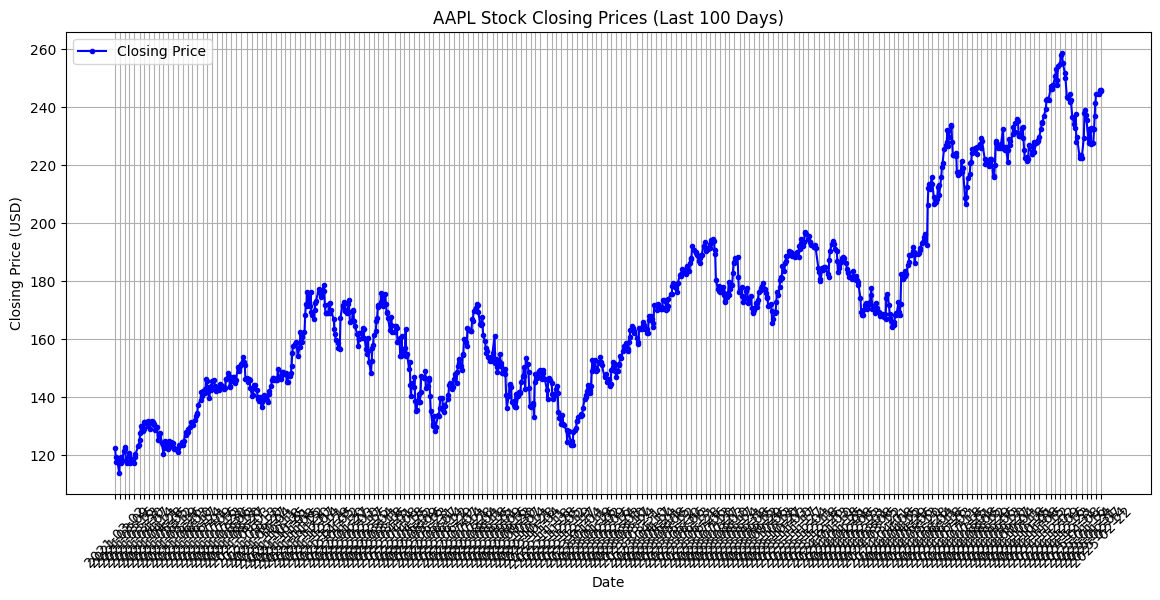

In [ ]:
import matplotlib.pyplot as plt

# Convert index to timezone-naive to avoid errors
df.index = df.index.tz_localize(None)

# Plot Closing Price over Time
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'], label="Closing Price", color="blue", marker="o", markersize=3)

# Formatting
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.title(f"{symbol} Stock Closing Prices (Last 100 Days)")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show every 5th date to avoid clutter
plt.xticks(df.index[::5], df.index.strftime("%Y-%m-%d")[::5])

# Show Plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import datetime

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    # Convert input dates to Pandas Timestamps
    first_date = pd.Timestamp(first_date_str).tz_localize(None)  # Ensure naive timestamp
    last_date = pd.Timestamp(last_date_str).tz_localize(None)  # Ensure naive timestamp

    # Ensure the dataframe index is timezone-naive
    dataframe = dataframe.copy()
    dataframe.index = dataframe.index.tz_localize(None)

    target_date = first_date
    dates, X, Y = [], [], []

    while target_date <= last_date:
        # Ensure enough previous data exists
        df_subset = dataframe.loc[:target_date].tail(n + 1)
        if len(df_subset) != n + 1:
            print(f'Skipping {target_date}: Not enough previous data for window size {n}')
            target_date += datetime.timedelta(days=1)
            continue  # Skip this date and move to the next one

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # Move to the next available date in the dataset
        next_dates = dataframe.loc[target_date:].index[1:]
        if next_dates.empty:
            break
        target_date = next_dates[0]

    # Create DataFrame from collected data
    ret_df = pd.DataFrame({"Target Date": dates})

    X = np.array(X)
    for i in range(n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df["Target"] = Y
    return ret_df

# Run the function safely with new date range
windowed_df = df_to_windowed_df(df, '2021-03-04', '2025-02-22 ', n=3)
print(windowed_df)


Skipping 2021-03-04 00:00:00: Not enough previous data for window size 3
    Target Date    Target-3    Target-2    Target-1      Target
0    2021-03-05  122.397476  119.404068  117.516045  118.777977
1    2021-03-08  119.404068  117.516045  118.777977  113.828094
2    2021-03-09  117.516045  118.777977  113.828094  118.455154
3    2021-03-10  118.777977  113.828094  118.455154  117.369308
4    2021-03-11  113.828094  118.455154  117.369308  119.306213
..          ...         ...         ...         ...         ...
993  2025-02-18  236.869995  241.529999  244.600006  244.470001
994  2025-02-19  241.529999  244.600006  244.470001  244.869995
995  2025-02-20  244.600006  244.470001  244.869995  245.830002
996  2025-02-21  244.470001  244.869995  245.830002  245.550003
997  2025-02-22  244.869995  245.830002  245.550003  245.830002

[998 rows x 5 columns]


In [ ]:
import numpy as np

def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]  # Extract target dates

    middle_matrix = df_as_np[:, 1:-1]  # Extract past values (features)
    X = middle_matrix.reshape((middle_matrix.shape[0], middle_matrix.shape[1], 1))  # Reshape for LSTM input

    Y = df_as_np[:, -1]  # Extract target values

    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

print("Dates shape:", dates.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)


Dates shape: (998,)
X shape: (998, 3, 1)
y shape: (998,)


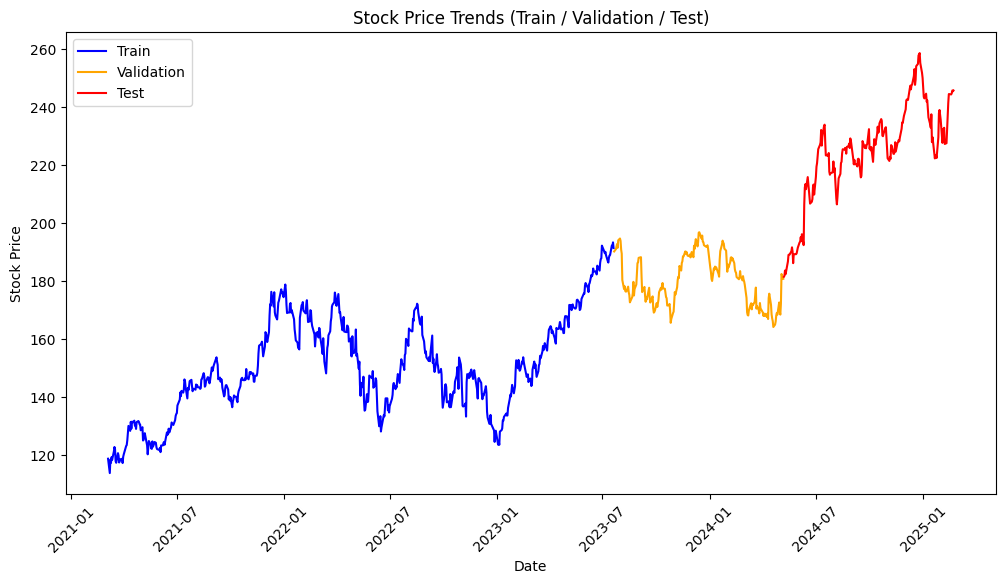

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Convert dates to datetime (remove timezone)
dates = pd.to_datetime(dates).tz_localize(None)

# Splitting dataset (80% train, 10% val, 10% test)
q_80 = int(len(dates) * 0.6)
q_90 = int(len(dates) * 0.8)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(dates_train, y_train, label="Train", color='blue')
plt.plot(dates_val, y_val, label="Validation", color='orange')
plt.plot(dates_test, y_test, label="Test", color='red')

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Trends (Train / Validation / Test)")
plt.xticks(rotation=45)
plt.show()


In [ ]:
print(y_train)

[118.77798  113.828094 118.455154 117.36931  119.30621  118.396454
 121.29205  122.83769  122.0453   117.90733  117.3791   120.70514
 119.87361  117.47691  117.96605  118.572556 118.74863  117.291046
 119.4921   120.3236   123.16051  123.46375  125.11697  127.52345
 130.10603  128.38431  131.50488  129.15714  131.57336  131.2408
 131.90596  130.21361  130.59514  129.06908  131.39732  131.7886
 131.46577  130.67336  130.57555  128.59952  129.65598  125.06806
 125.31264  126.916954 127.593094 124.30061  123.37949  120.3026
 122.45838  124.88854  123.73225  122.3408   122.18401  124.75136
 122.90914  124.54558  124.349594 124.30061  122.76214  122.10562
 121.78224  122.54658  121.05713  123.3599   123.3697   124.19282
 124.574974 123.57547  124.790565 127.857635 127.03454  127.53428
 129.14131  127.83805  129.64108  131.28734  131.01295  130.72876
 130.43477  132.07121  133.59012  134.2074   134.51118  137.14714
 139.16571  141.66447  140.36122  142.1936   141.59586  142.71297
 146.15242 

In [ ]:
!pip install tensorflow numpy pandas matplotlib scikit-learn


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler


In [ ]:
# Normalize Data
scaler = MinMaxScaler(feature_range=(0,1))
X_train = scaler.fit_transform(X_train.reshape(-1, 3)).reshape(-1, 3, 1)
X_val = scaler.transform(X_val.reshape(-1, 3)).reshape(-1, 3, 1)
X_test = scaler.transform(X_test.reshape(-1, 3)).reshape(-1, 3, 1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 23023.9746 - mean_absolute_error: 150.7792 - val_loss: 32316.2480 - val_mean_absolute_error: 179.5605
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22510.0430 - mean_absolute_error: 149.1105 - val_loss: 31840.2891 - val_mean_absolute_error: 178.2355
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21954.1406 - mean_absolute_error: 147.3073 - val_loss: 29820.3906 - val_mean_absolute_error: 172.4962
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20398.1191 - mean_absolute_error: 141.9930 - val_loss: 23425.6426 - val_mean_absolute_error: 152.8705
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14976.7725 - mean_absolute_error: 121.4324 - val_loss: 13912.1758 - val_mean_absolute_error: 117.7024
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7480.2974 - mean_absolute_error: 84.9873 - val_loss: 6098.3408 - val_mean_absolute_error: 77.6890
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━

In [ ]:
print(y_train)

[118.77798  113.828094 118.455154 117.36931  119.30621  118.396454
 121.29205  122.83769  122.0453   117.90733  117.3791   120.70514
 119.87361  117.47691  117.96605  118.572556 118.74863  117.291046
 119.4921   120.3236   123.16051  123.46375  125.11697  127.52345
 130.10603  128.38431  131.50488  129.15714  131.57336  131.2408
 131.90596  130.21361  130.59514  129.06908  131.39732  131.7886
 131.46577  130.67336  130.57555  128.59952  129.65598  125.06806
 125.31264  126.916954 127.593094 124.30061  123.37949  120.3026
 122.45838  124.88854  123.73225  122.3408   122.18401  124.75136
 122.90914  124.54558  124.349594 124.30061  122.76214  122.10562
 121.78224  122.54658  121.05713  123.3599   123.3697   124.19282
 124.574974 123.57547  124.790565 127.857635 127.03454  127.53428
 129.14131  127.83805  129.64108  131.28734  131.01295  130.72876
 130.43477  132.07121  133.59012  134.2074   134.51118  137.14714
 139.16571  141.66447  140.36122  142.1936   141.59586  142.71297
 146.15242 

In [ ]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
[119.002846 116.05227  114.209785 114.130806 111.47819  115.28477
 114.953125 116.65655  117.17771  119.968925 120.34021  118.166664
 115.03469  115.6908   117.78541  116.30959  114.57598  115.23468
 115.59166  115.52865  115.23873  117.77531  119.506096 122.11326
 123.25875  125.71451  128.15627  129.95192  129.35777  131.23909
 130.23428  131.9896   131.72942  131.73401  130.40773  130.51787
 130.18706  131.97438  132.05174  131.55443  130.67659  130.11836
 128.3629   127.700226 124.49051  125.31304  126.31045  125.60863
 122.30416  120.81544  119.44495  121.85413  123.17393  121.76359
 120.966286 121.47262  123.09588  122.17922  123.39099  123.00457
 122.34704  120.85305  120.323555 120.11916  120.53964  120.15316
 122.10783  122.45287  123.08974  123.21914  123.281624 125.14916
 127.287025 127.0482   127.77456  128.80394  128.63734  130.469
 131.55151  131.22165  131.14043  131.64644  133.38918  134.70534
 135.58173  136.85303  139.58928  141

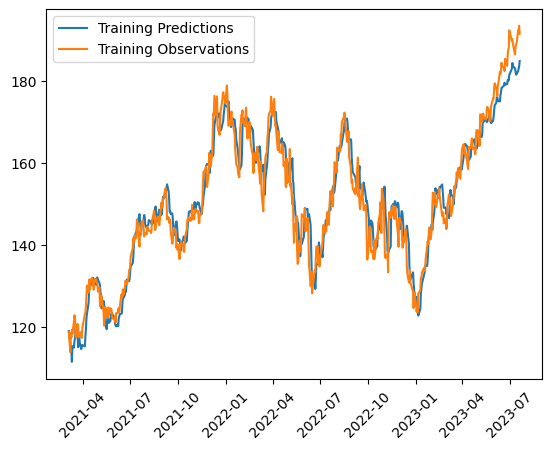

In [ ]:
train_predictions = model.predict(X_train).flatten()
print(train_predictions)
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.xticks(rotation=45)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


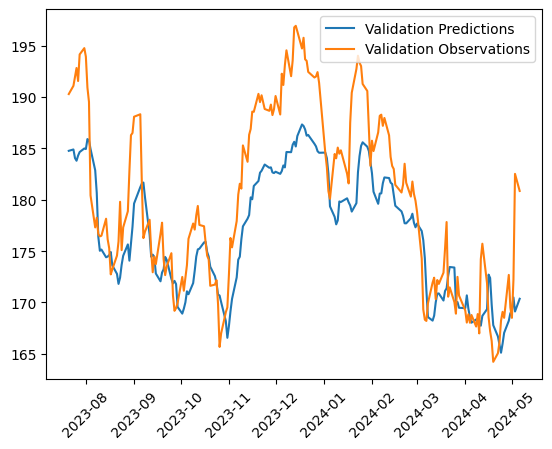

In [ ]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.xticks(rotation=45)
plt.legend(['Validation Predictions', 'Validation Observations'])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


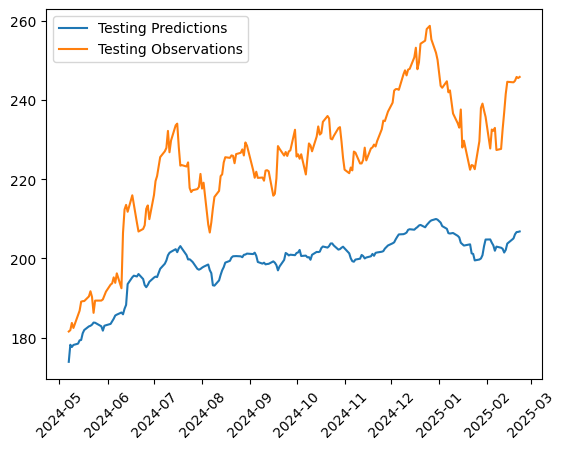

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.xticks(rotation=45)
plt.legend(['Testing Predictions', 'Testing Observations'])

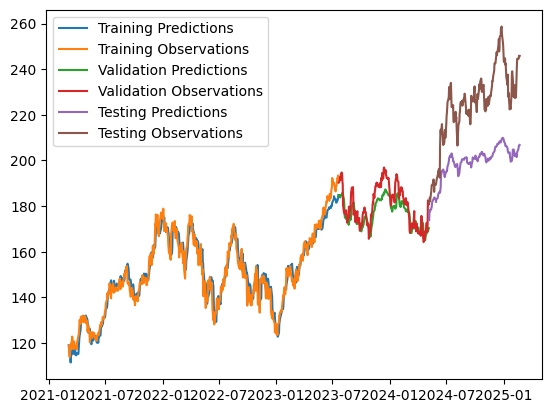

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
future_prices = []
input_seq = X_test[-1].reshape(1, 3, 1)  # Start with last known sequence

for _ in range(7):  # Predict next 7 days
    next_price = model.predict(input_seq)[0][0]
    future_prices.append(next_price)

    # Update input sequence (remove oldest value, add new prediction)
    input_seq = np.append(input_seq[:, 1:, :], [[[next_price]]], axis=1)

print("Predicted Closing Prices for Next 7 Days:", future_prices)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Closing Prices for Next 7 Days: [206.8121, 218.65993, 213.02498, 227.8601, 227.90395, 227.6993, 227.69821]


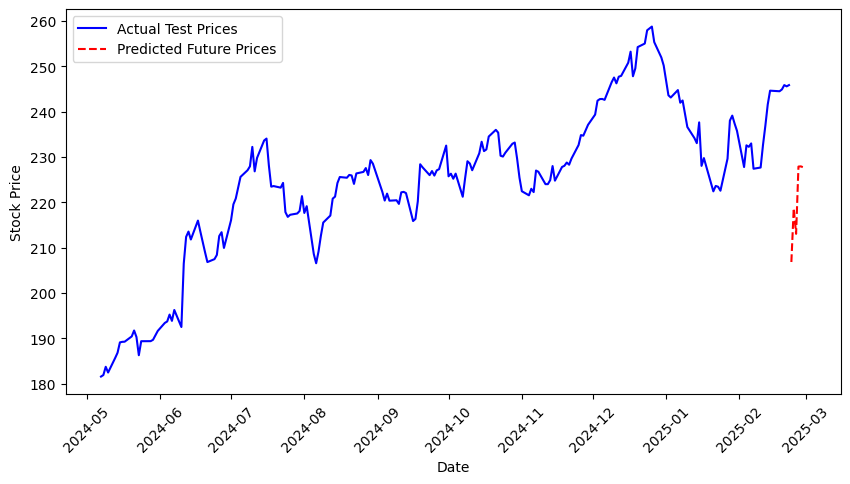

In [ ]:
import matplotlib.pyplot as plt
import datetime

# Generate future dates
future_dates = [dates_test[-1] + datetime.timedelta(days=i) for i in range(1, 8)]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dates_test, y_test, label='Actual Test Prices', color='blue')
plt.plot(future_dates, future_prices, label='Predicted Future Prices', color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45)  # You can change to 30, 60, or 90 degrees

plt.show()

